# Deep Contextualized Word Representations
## ELMo: Embeddings from Language Models
Peters, M.E., Neumann, M., Iyyer, M., Gardner, M., Clark, C., Lee, K. and Zettlemoyer, L., 2018. Deep Contextualized Word Representations. In _Proceedings of the 2018 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies_, Volume 1 (Long Papers) (pp. 2227–2237)

### Import Statements

In [1]:
%tensorflow_version 1.x

import random

import tensorflow_hub as hub
import tensorflow as tf

from IPython.display import Image

TensorFlow 1.x selected.


### Bi-directional Language Models
ELMo is is a word representation that is based on the internal states of a bi-directional LSTM. Specifically, the LSTM is trained with a language model (LM) objective. In this way, the trained representation is **_contextual_**, in that it can differentiate between polysemes: the word "mouse" in the phrase "the cat caught a mouse" will have a different embedding from that in the phrase "he loves his new gaming mouse". The original version of ELMo uses a two-layered LSTM, i.e., $L = 2$.

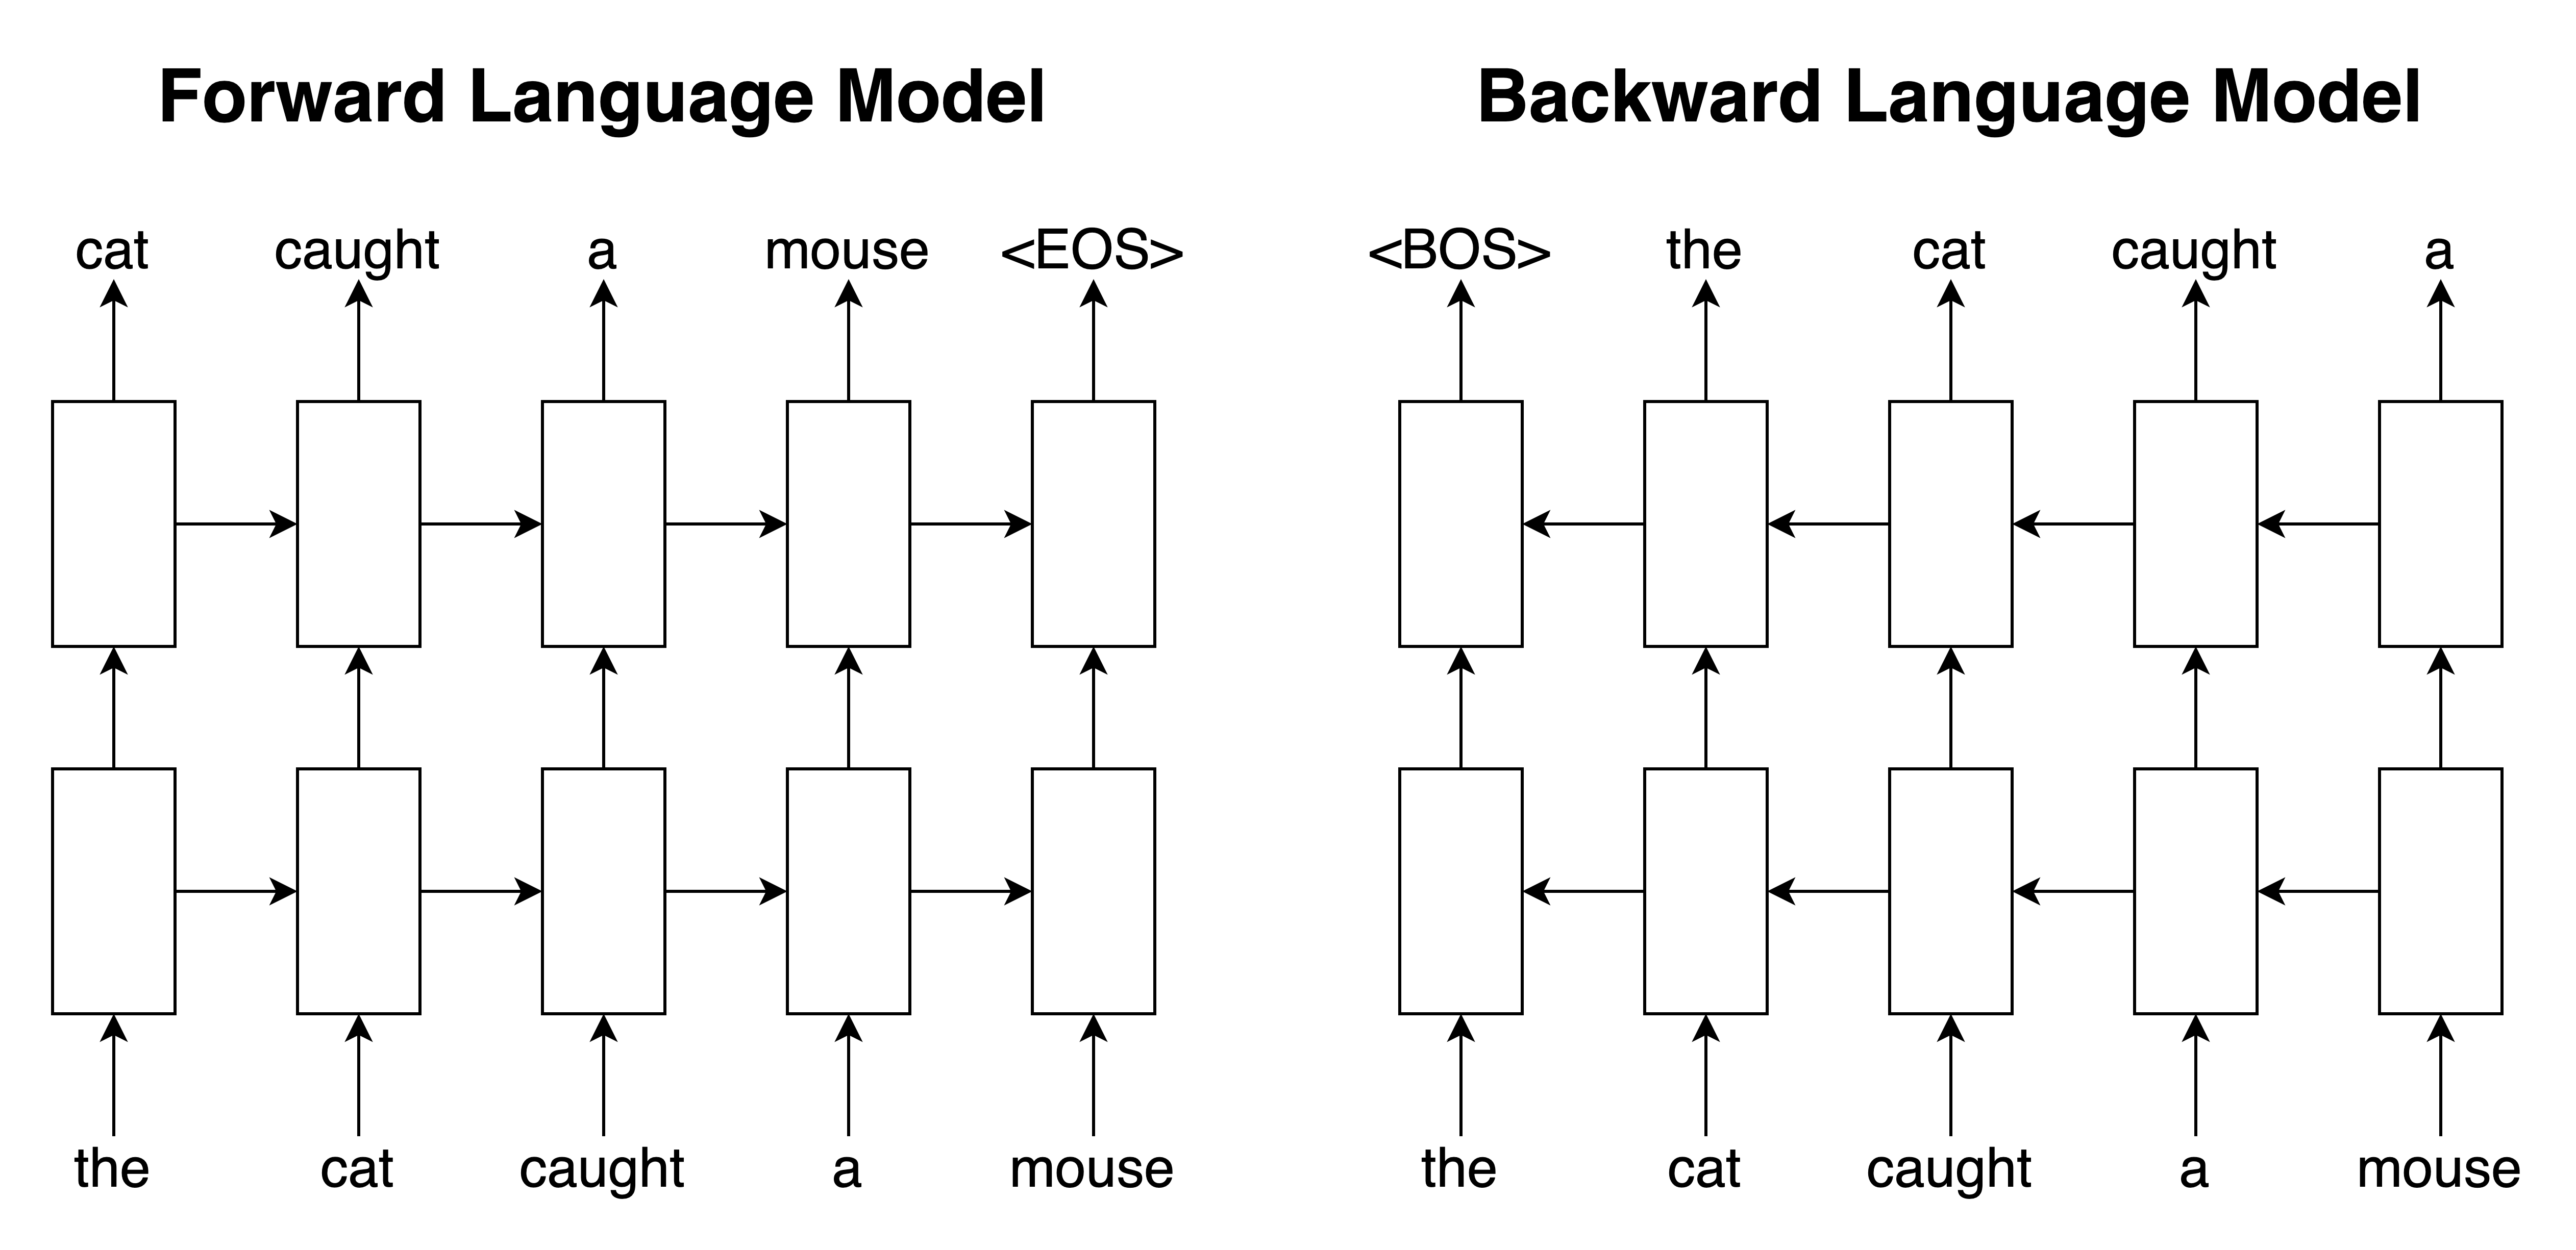

In [2]:
Image('figures/language_models.png', width=960)

A forward LM is able to predict the probability of a sequence of words by modeling the probability of the next word given its historical context (i.e. the words that preceded it).

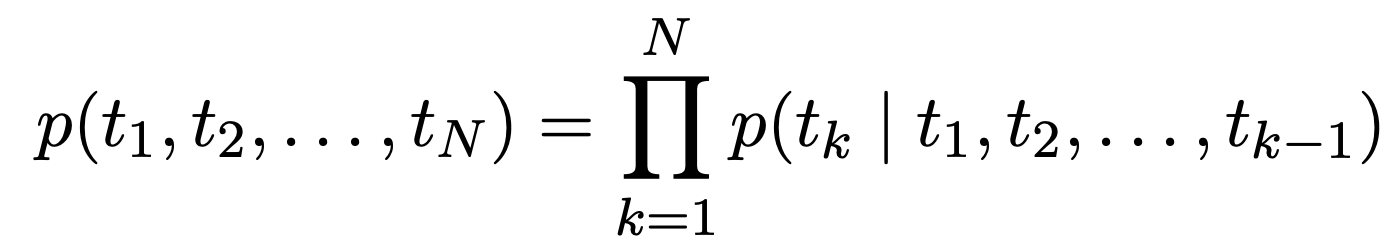

In [3]:
Image('figures/historical_context.png', width=480)

Meanwhile, a backward LM predicts the probability of a sequence by modeling the probability of the previous word given its future context.

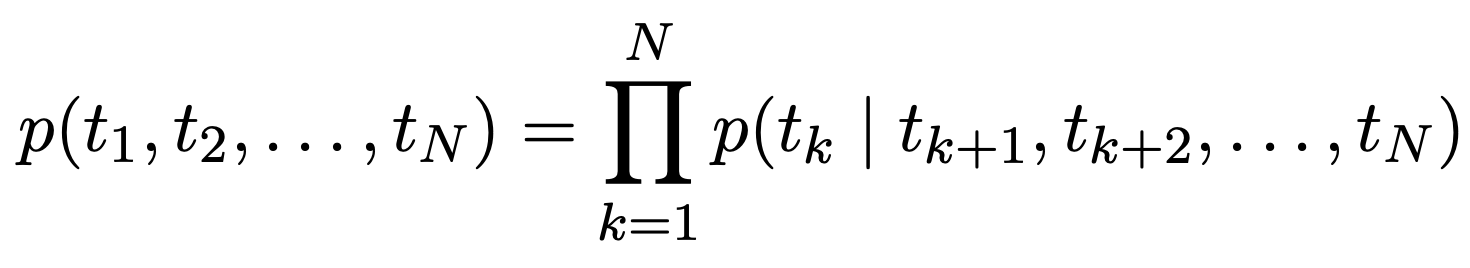

In [4]:
Image('figures/future_context.png', width=480)

ELMO uses both a forward LM and a backward LM by jointly maximizing the log-likelihood of both directions.

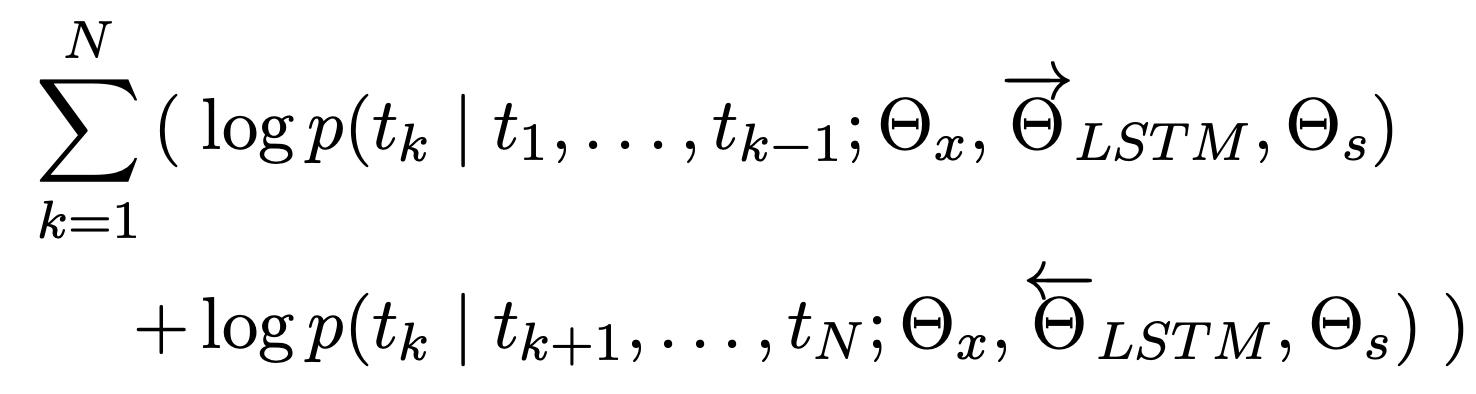

In [5]:
Image('figures/joint_maximization.png', width=480)

### Character-Level Embeddings

Furthermore, instead of using existing embeddings (e.g., GloVe, word2vec) to pre-process input string sequences before they are passed to the LSTM, ELMo uses character-level embeddings. Crucially, this allows ELMo to produce embeddings for out-of-vocabulary words by relying on **_morphological clues_**. This means that a good attempt can be made at embedding misspelled words (e.g., "necessary" vs. "necesary") or derived forms (e.g., "superficial" → "superficiality") even if they do not appear in the training corpus.

Note that ${\bf{x}}^{LM}_{k}$, the output of the character embedding layers for the $k$-th token, is a component of the final embedding generated by ELMo for the $k$-th token .

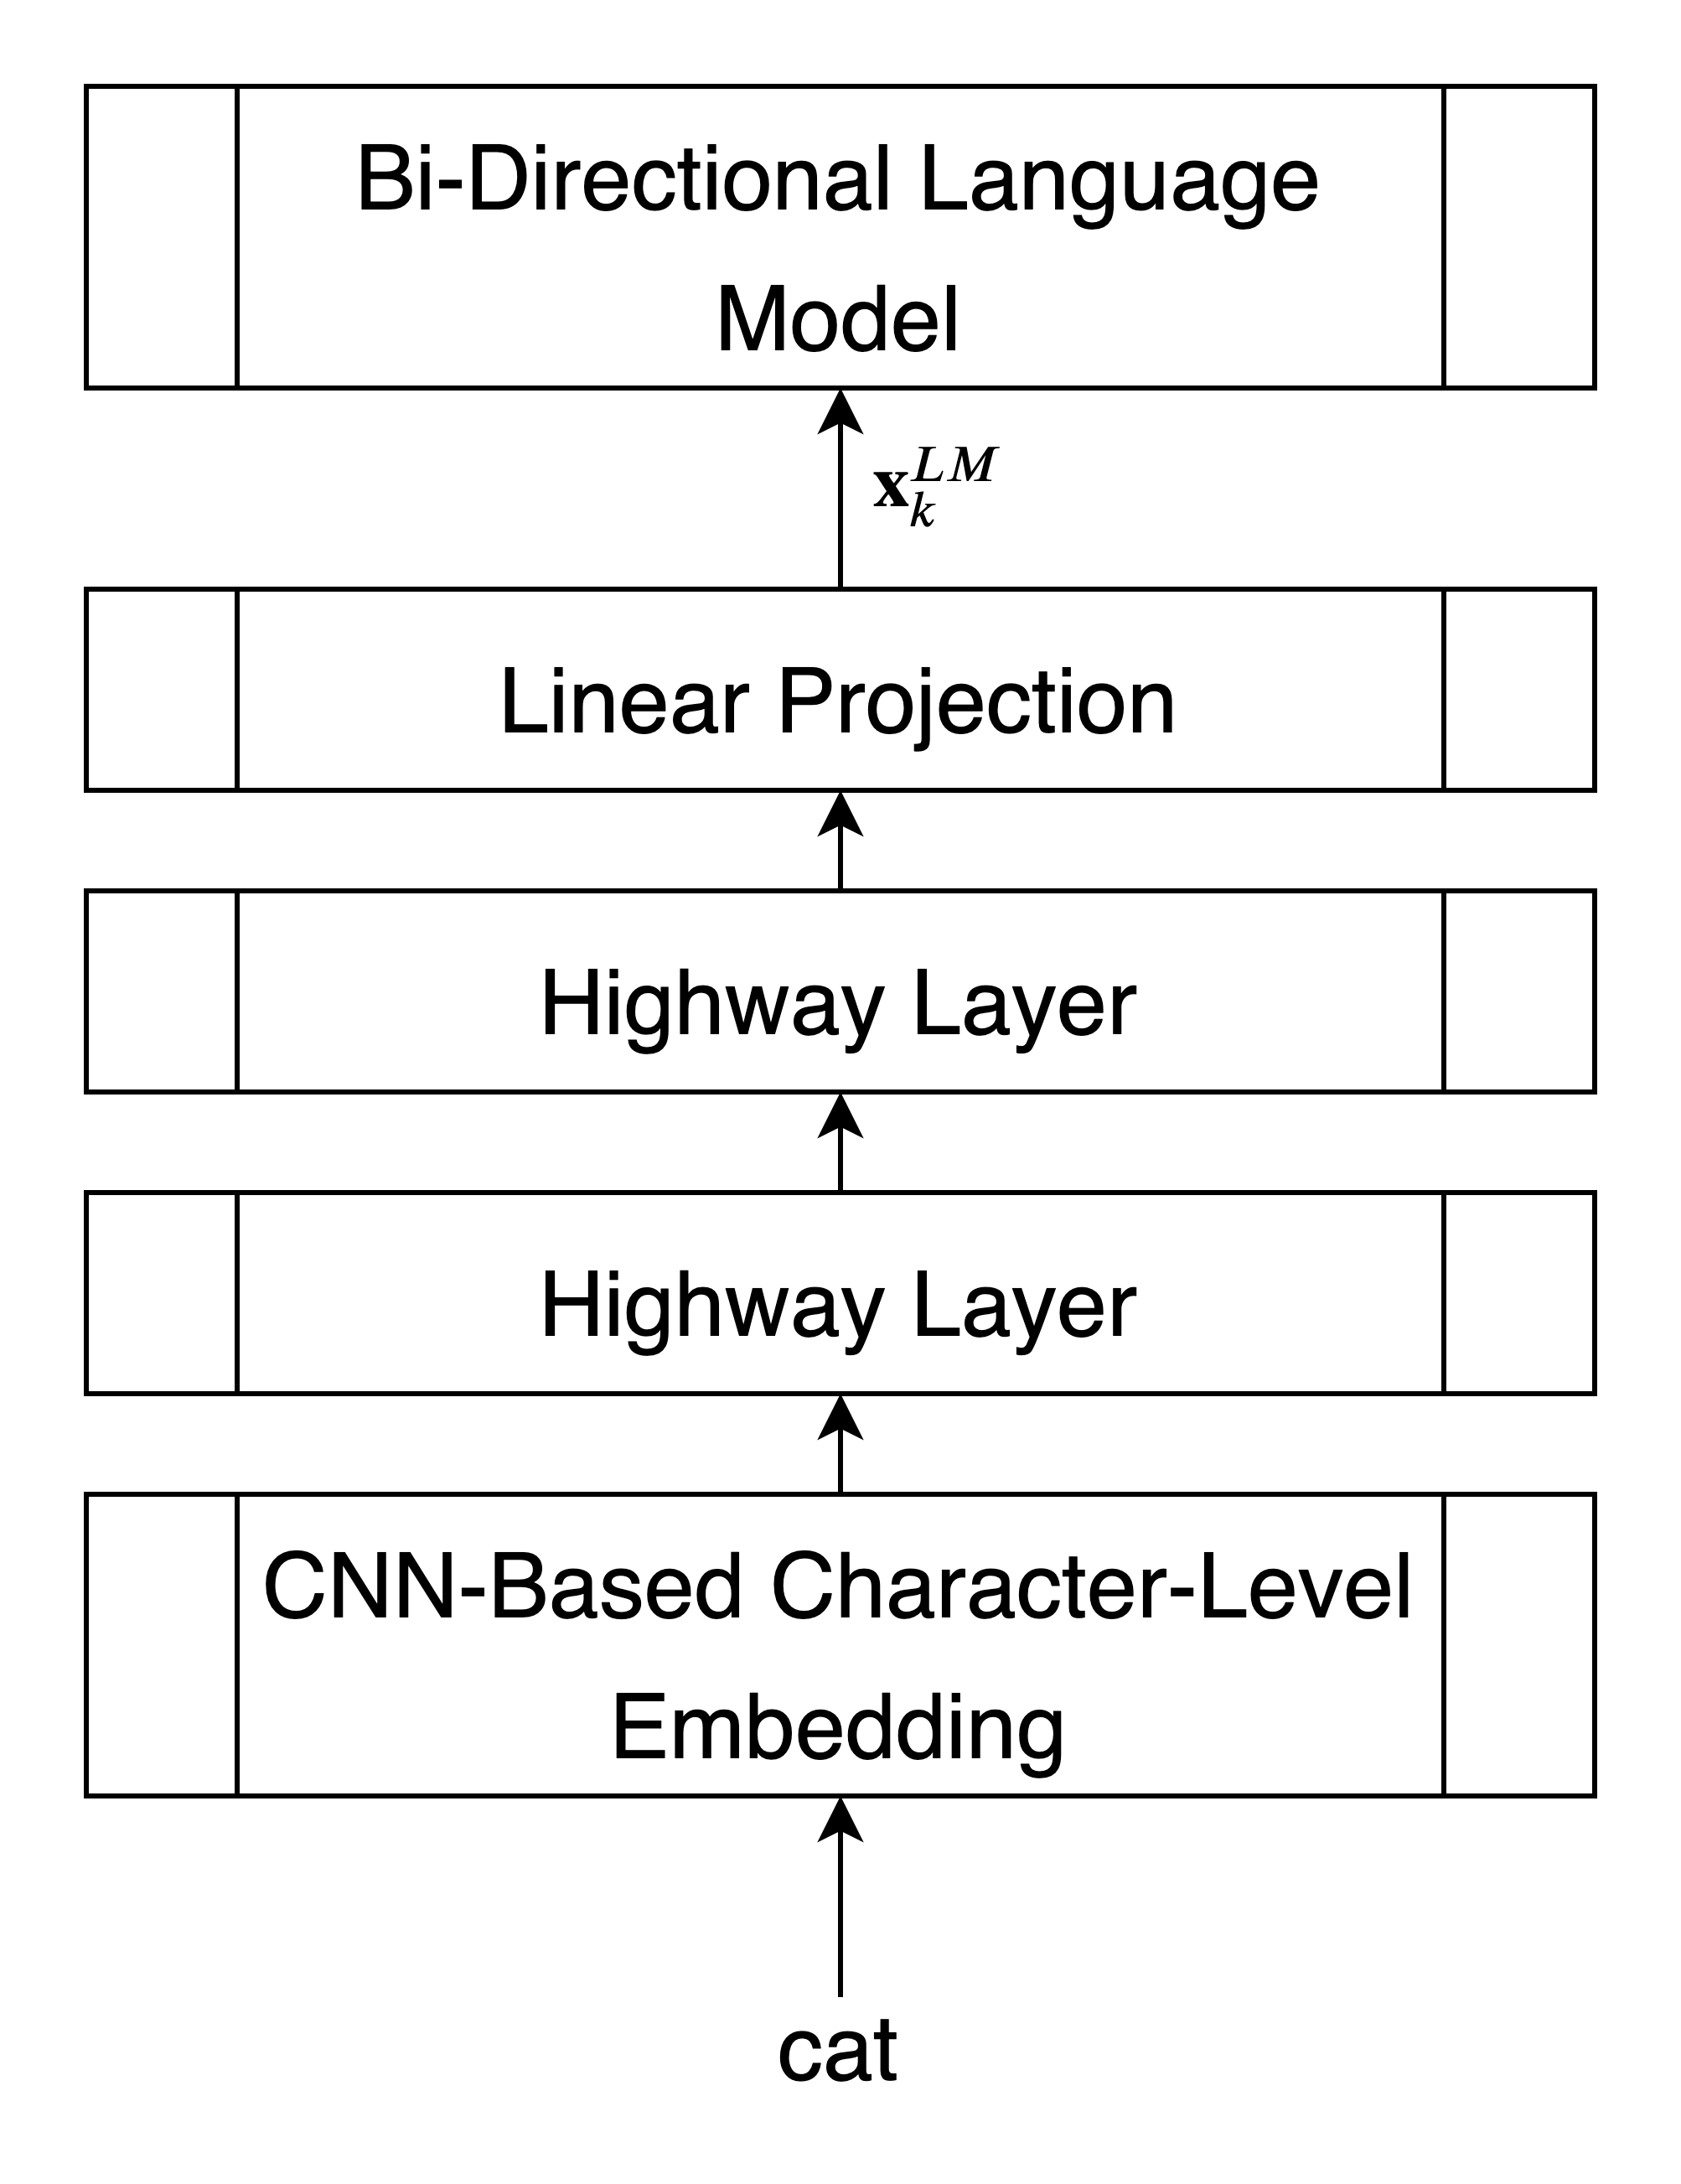

In [6]:
Image('figures/overview.png', width=360)

It should be noted that the character embedding is not merely just passed to the first LSTM layer; it is also passed to the second layer via residual connections.

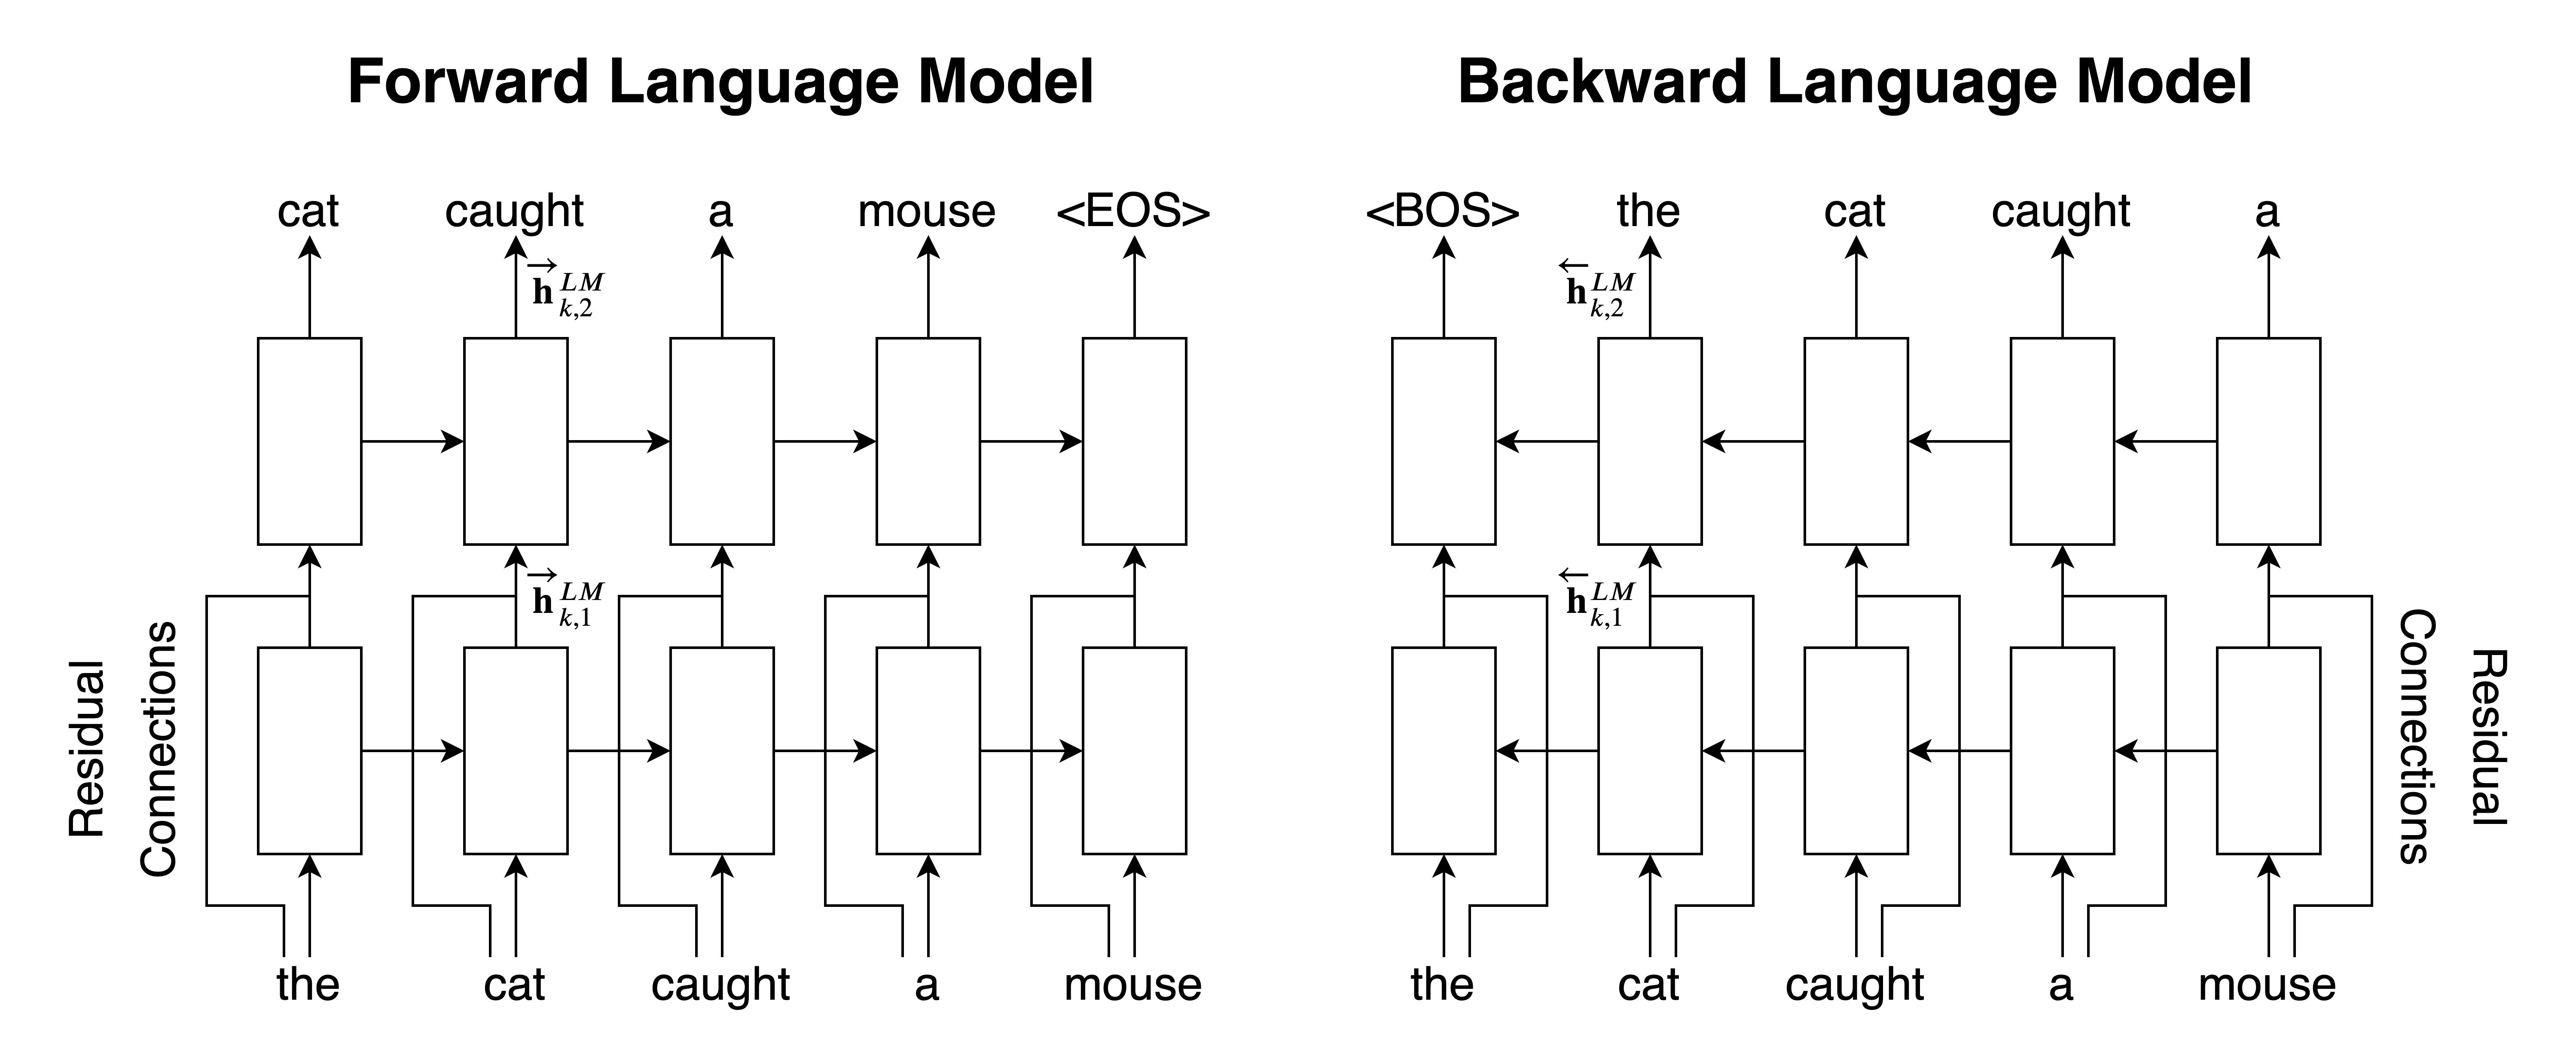

In [7]:
Image('figures/language_models_with_residual_connections.png', width=1080)

### ELMo Embeddings

The other components of the final embedding are derived from the $L$ LSTM layers' hidden states. For the $j$-th layer, we have $\overrightarrow{\bf{h}}{}^{LM}_{k,j}$ and $\overleftarrow{\, \bf{h}}{}^{LM}_{k,j}$ for the forward and backward LSTMs respectively (also shown in the above figure). The two hidden states for each layer are concatenated to obtain ${\bf{h}}^{LM}_{k,j}$.

Note that the LSTM layers are indexed starting from 1, and the character embedding mentioned above is given the 0 index, i.e., ${\bf{h}}^{LM}_{k,0} = {\bf{x}}^{LM}_{k}$.

Thus, the final representation has $L + 1$ members, one for each representation layer in ELMo.

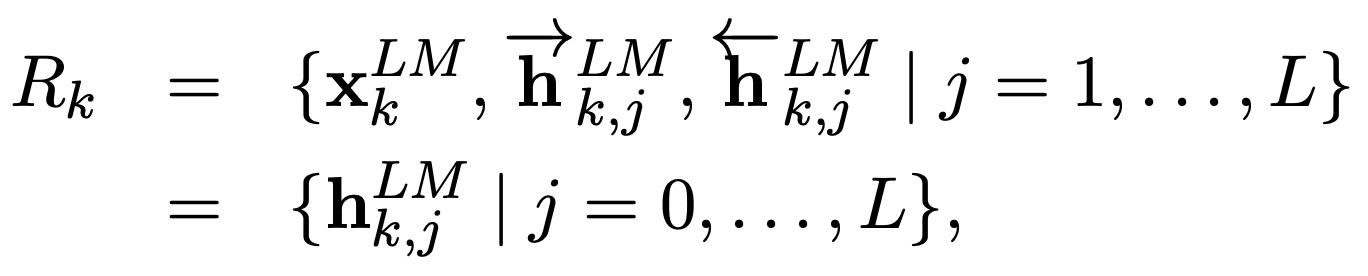

In [8]:
Image('figures/representation.png', width=480)

The authors showed that different downstream tasks benefit from different layers' representations. Better performance is obtained with the last layer for meaning-related tasks like word sense disambiguation, while the first LSTM layer gives better performance for grammar-relatelated tasks like part-of-speech tagging. The intuition here is that lower layer(s) are better at encoding syntactic information, while higher layer(s) are better at encoding semantic information. This suggests that representations at all layers of the LSTM can have varying effects on the performance on downstream tasks (depending on the type of task involved).

And thus, we arrive at the main contribution of ELMo: the final embedding can be customized for different downstream tasks by learning a **_task-specific weighting_** $s^{task}_{j}$ of ${\bf{h}}^{LM}_{k,j}$. Here, $\gamma^{task}$ is a scaling factor used to scale the entire ELMo output to account for distributional differences between the biLM representations and the task-specific representations.

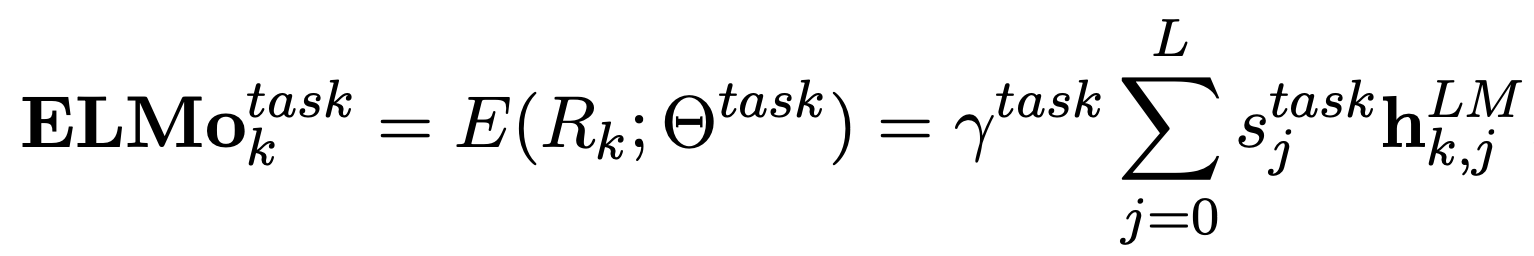

In [9]:
Image('figures/weighting.png', width=480)

### Demonstration

Let's try using pre-trained ELMo embeddings for a text classification task. We'll use the IMDB movie reviews sentiment dataset.

In [0]:
sess = tf.Session()

tf.keras.backend.set_session(sess)
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(start_char=0,
                                                                        oov_char=0,
                                                                        index_from=1)

In [0]:
word_index = tf.keras.datasets.imdb.get_word_index()
word_index = {(v + 1):k for k, v in word_index.items()}
word_index[0] = ''

In [0]:
for i, seq in enumerate(x_train):
  x_train[i] = ' '.join(word_index[idx] for idx in x_train[i])
  x_test[i] = ' '.join(word_index[idx] for idx in x_test[i])

In [14]:
x_train

array([" this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

Since the full dataset is pretty big (25,000 reviews each in the training and test set), we'll just use a small subset of the dataset.

In [0]:
train_subset = random.sample(range(len(x_train)), 250)
test_subset = random.sample(range(len(x_test)), 200)

We retrieve the trained model from [TensorFlow Hub](https://tfhub.dev/google/elmo/3), setting the `trainable` argument to `False` to freeze the weights of the ELMo model (again, to save on compute). If one wishes to fine-tune the model for a specific task, this can be set as `True`.

The `signature` argument indicates the input format: `default` is used for untokenized sequences, while `tokens` is used for tokenized sequences.

There are five options for the output dictionary:
 - `word_emb`: the character-based word representations with shape `[batch_size, max_length, 512]`;
 - `lstm_outputs1`: the first LSTM hidden state with shape `[batch_size, max_length, 1024]`;
 - `lstm_outputs2`: the second LSTM hidden state with shape `[batch_size, max_length, 1024]`;
 - `elmo`: the weighted sum of the 3 layers, where the weights are trainable, with shape `[batch_size, max_length, 1024]`;
 - `default`: a fixed mean-pooling of all contextualized word representations with shape `[batch_size, 1024]`.

In [0]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)
def ElmoEmbedding(x):
  return elmo_model(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

Here, we define the rest of the model. We'll use a very simple model with a single dense hidden layer with 128 units.

In [0]:
def build_model(sess):
  sess.run(tf.global_variables_initializer())
  sess.run(tf.tables_initializer())
  
  model = tf.keras.Sequential()
  
  input_text = tf.keras.Input(shape=(1,), dtype=tf.string)
  embedding = tf.keras.layers.Lambda(ElmoEmbedding, output_shape=(1024,))(input_text)
  dense = tf.keras.layers.Dense(128, activation="relu")(embedding)
  pred = tf.keras.layers.Dense(1, activation="sigmoid")(dense)
  
  model = tf.keras.Model(inputs=[input_text], outputs=pred)
  model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["binary_accuracy"])
  
  return model

In [0]:
model = build_model(sess)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 131,329
Trainable params: 131,329
Non-trainable params: 0
_________________________________________________________________


Now, we train the model. Note that our training set has only 200 reviews, while the model has 131,329 trainable parameters! Will it overfit?

In [20]:
model.fit(x_train[train_subset],
          y_train[train_subset],
          epochs=10,
          batch_size=10,
          validation_split=0.2)

Train on 200 samples, validate on 50 samples
Epoch 1/10
200/200 [==============================] - 54s 270ms/sample - loss: 0.6794 - binary_accuracy: 0.6050 - val_loss: 0.6630 - val_binary_accuracy: 0.5600
Epoch 2/10
200/200 [==============================] - 45s 227ms/sample - loss: 0.6163 - binary_accuracy: 0.6850 - val_loss: 0.5882 - val_binary_accuracy: 0.6200
Epoch 3/10
200/200 [==============================] - 41s 205ms/sample - loss: 0.5495 - binary_accuracy: 0.7250 - val_loss: 0.6105 - val_binary_accuracy: 0.6400
Epoch 4/10
200/200 [==============================] - 41s 204ms/sample - loss: 0.4812 - binary_accuracy: 0.7350 - val_loss: 0.5655 - val_binary_accuracy: 0.7000
Epoch 5/10
200/200 [==============================] - 43s 214ms/sample - loss: 0.4539 - binary_accuracy: 0.8150 - val_loss: 0.5290 - val_binary_accuracy: 0.7600
Epoch 6/10
200/200 [==============================] - 41s 204ms/sample - loss: 0.4565 - binary_accuracy: 0.7800 - val_loss: 0.5300 - val_binary_accura

Now, let's evaluate the model on the test set.

In [21]:
model.evaluate(x_test[test_subset],
               y_test[test_subset],
               batch_size=10)

200/200 [==============================] - 35s 175ms/sample - loss: 0.4501 - binary_accuracy: 0.7850


[0.45005825012922285, 0.785]

It actually does really well! Oh, and this **is** a balanced dataset.

In [22]:
print("Size of test set:", len(y_test[test_subset]))
print("Number of positive labels:", sum(y_test[test_subset]))

Size of test set: 200
Number of positive labels: 101


Basically, I'm a huge fan!

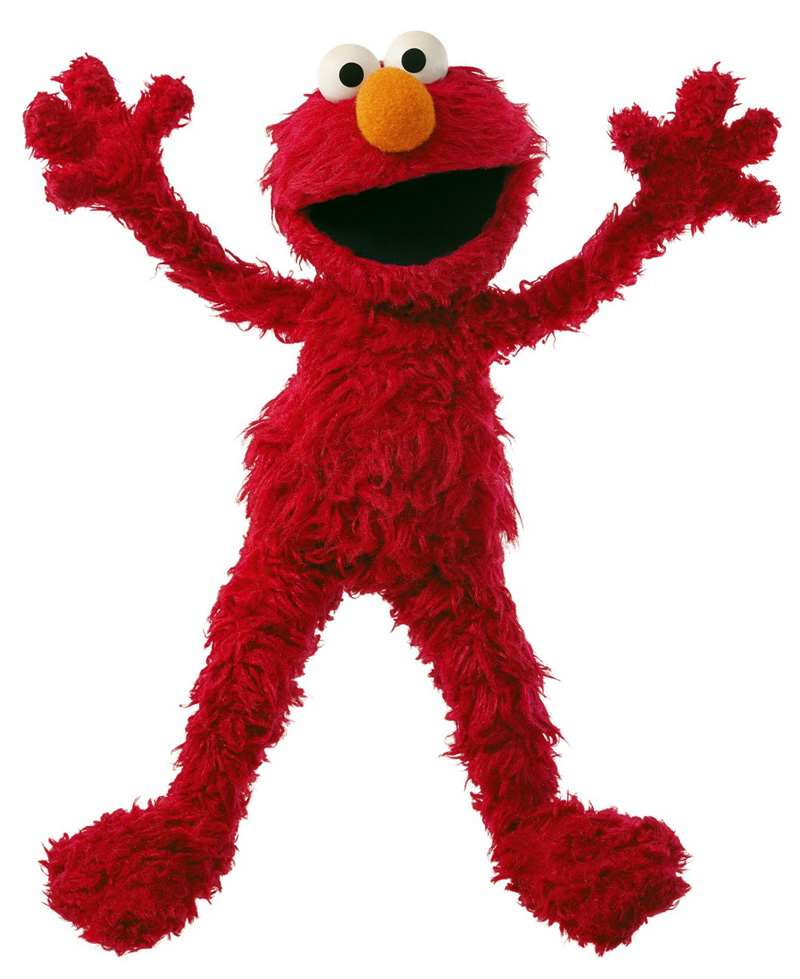

In [23]:
Image('figures/elmo.jpg', width=360)